In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [45]:
df = pd.read_excel("Case Prediction Data2.xlsx")
df.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,204977,Efile Acceptance,2017-01-02 05:39:00,2017-01-03 09:03:00,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have not received the acceptance/rejection confirmation.,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor
1,204979,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,2017-01-02 09:03:00,2017-01-04 16:56:00,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,Provision,State,NaN,NaN,US.OR,Customer no longer needs assistance,NaN,NaN
2,204980,Data map incorrectly pulling in values,2017-01-02 11:25:00,2017-01-03 15:48:00,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports are not posting as expected,Office - Excel Add-In,Import / Export,NaN,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula in the Advanced formula setting of the Data Templat...
3,204981,The New Corptax Connect Website is not properly working,2017-01-02 12:06:00,2017-01-03 09:26:00,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system. It hasn't functioned properly since the change. ...,Websites,Connections (https://connect.corptax.com),Error Message,NaN,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wrong while loading this page
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03 07:17:00,2017-01-05 08:21:00,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and Taxable income per the LD400 does not tie to the ...


In [46]:
df_comp = df[df.Product == "Compliance"]
df_comp['Date Created'] = df_comp['Date Created'].dt.date
df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [47]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf['Date'] = pd.to_datetime(newdf['Date'])
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
newdf

,Case Number
Date,
2017-01-31,1066.0
2017-02-28,1300.0
2017-03-31,2092.0
2017-04-30,1247.0
2017-05-31,1407.0
...,...
2022-04-30,914.0
2022-05-31,777.0
2022-06-30,952.0


In [48]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2017-01-31 to 2022-08-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Case Number  68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [61]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f.generate_future_dates(12)
f.set_test_length(.2)
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 1.01
the p-value is 0.9944
the series is not stationary
----------------------------------------------------------------------------------------------------


# MLR Forecasting

In [62]:
f.set_estimator('mlr') # 1. choose the mlr estimator
f.add_ar_terms(12) # 2. add regressors (12 lagged terms)
f.add_seasonal_regressors('quarter',dummy=True) # 2.
f.add_time_trend() # 2.
f.diff() # 3. difference non-stationary data

<AxesSubplot:xlabel='Date', ylabel='Values'>

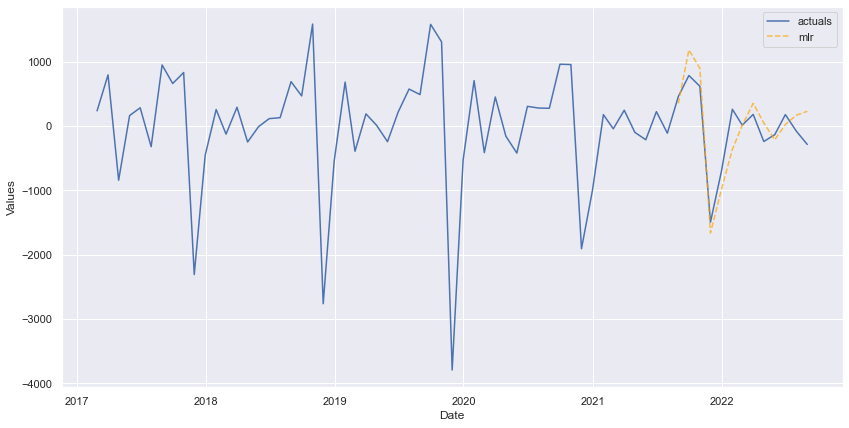

In [63]:
f.manual_forecast()
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2')

In [64]:
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -3.73
the p-value is 0.0037
the series is stationary
----------------------------------------------------------------------------------------------------


<AxesSubplot:xlabel='Date', ylabel='Values'>

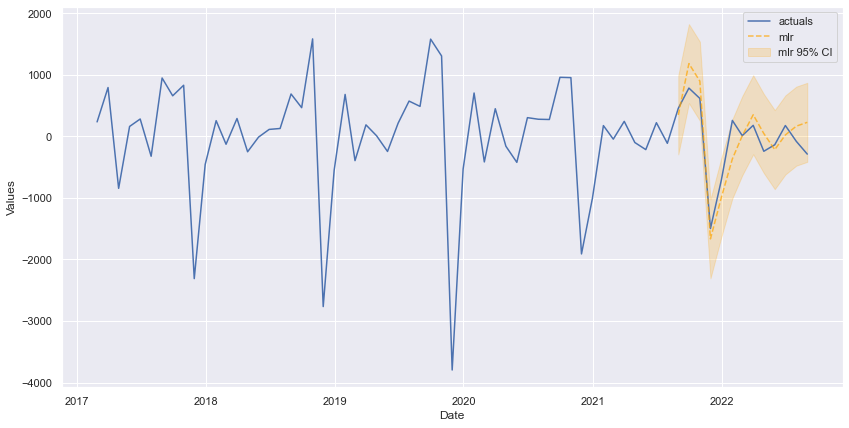

In [52]:
f.plot_test_set(models='mlr',ci=True)

<AxesSubplot:xlabel='Date', ylabel='Values'>

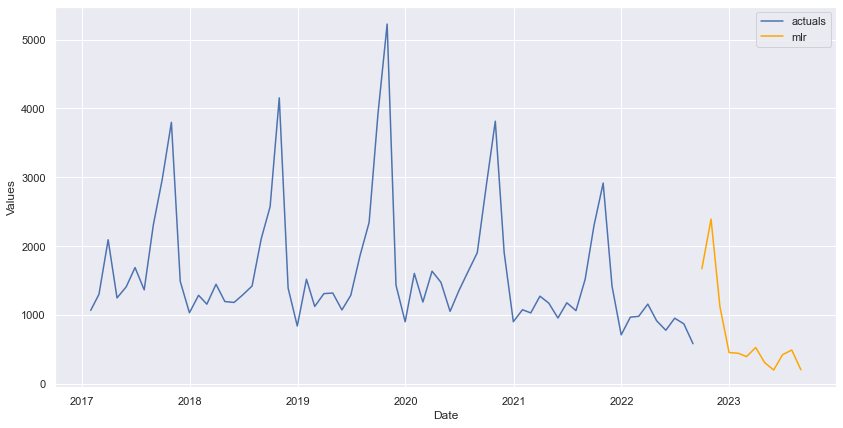

In [53]:
f.plot(models='mlr',
       order_by='LevelTestSetMAPE',
       level=True)

In [54]:
result_train = f.export_fitted_vals(model = "mlr")
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(result_train["Actuals"], result_train["FittedVals"]))
rms

348.525682135335

In [65]:
result_train["Actuals"]

0     -129.0
1      289.0
2     -251.0
3      -13.0
4      112.0
5      127.0
6      687.0
7      465.0
8     1582.0
9    -2765.0
10    -551.0
11     680.0
12    -395.0
13     186.0
14       9.0
15    -246.0
16     213.0
17     572.0
18     486.0
19    1578.0
20    1305.0
21   -3795.0
22    -531.0
23     703.0
24    -416.0
25     448.0
26    -161.0
27    -423.0
28     303.0
29     277.0
30     273.0
31     958.0
32     953.0
33   -1910.0
34   -1004.0
35     174.0
36     -46.0
37     243.0
38    -101.0
39    -216.0
40     221.0
41    -114.0
42     455.0
43     783.0
44     615.0
45   -1498.0
46    -707.0
47     258.0
48      11.0
49     178.0
50    -243.0
51    -137.0
52     175.0
53     -82.0
54    -289.0
Name: Actuals, dtype: float64

In [66]:
pd.options.display.max_colwidth = 100
# results = f.export(to_excel=True,
#                    excel_name='arima_results.xlsx',
#                    determine_best_by='TestSetMAPE')
results = f.export(to_excel=True,
                   excel_name='mlr.xlsx')
pd.set_option('display.max_columns', None)
results["model_summaries"]["TestSetRMSE"]

0    305.919158
Name: TestSetRMSE, dtype: float64

In [56]:
results["model_summaries"]["InSampleRMSE"]

0    348.525682
Name: InSampleRMSE, dtype: float64

In [68]:
results.keys()

dict_keys(['model_summaries', 'best_fcst', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [73]:
results["lvl_test_set_predictions"]

,DATE,actual,mlr
55,2021-08-31,1517.0,1409.723344
56,2021-09-30,2300.0,2590.563724
57,2021-10-31,2915.0,3485.962686
58,2021-11-30,1417.0,1820.455775
59,2021-12-31,710.0,831.113722
60,2022-01-31,968.0,464.229954
61,2022-02-28,979.0,472.964921
62,2022-03-31,1157.0,823.167176
63,2022-04-30,914.0,868.648026
64,2022-05-31,777.0,651.913483


In [57]:
results["lvl_fcsts"]

,DATE,mlr
0,2022-09-30,1671.078567
1,2022-10-31,2392.115919
2,2022-11-30,1121.668980
3,2022-12-31,453.429444
4,2023-01-31,442.886989
5,2023-02-28,393.739757
6,2023-03-31,526.729579
7,2023-04-30,308.848641
8,2023-05-31,199.390288
9,2023-06-30,421.475203


In [60]:
results["best_fcst"]

,DATE,VALUES,MODEL
0,2017-01-31,NaN,actual
1,2017-02-28,234.000000,actual
2,2017-03-31,792.000000,actual
3,2017-04-30,-845.000000,actual
4,2017-05-31,160.000000,actual
...,...,...,...
75,2023-04-30,-217.880939,mlr
76,2023-05-31,-109.458353,mlr
77,2023-06-30,222.084915,mlr
78,2023-07-31,68.637204,mlr


In [37]:
results["model_summaries"]["Xvars"][0]

['AR1',
 'AR2',
 'AR3',
 'AR4',
 'AR5',
 'AR6',
 'AR7',
 'AR8',
 'AR9',
 'AR10',
 'AR11',
 'AR12',
 'quarter',
 'quarter_1',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 't']